# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [3]:
warnings.simplefilter('ignore')

# Загрузим данные

In [4]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [5]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=2*0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        #x_centrir -= x_centrir.mean()
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean() 
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        

In [6]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    
    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            if (f<0.9):
                P=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            else:
                P=I-np.kron(kp,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
       
        return y

# Центрируем данные (замена: вместо 3-х методов теперь 2)

In [53]:
cen=centrir(testSize=0.1428,column_y=0)

In [54]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [55]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

# Делаем применение сразу по всем компонентам

In [62]:
npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}

In [63]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
r2_cv=gridCought.cv_results_[ "mean_test_score" ]
r2_c=gridCought.cv_results_[ "mean_train_score" ]
predictors=gridCought.predict(X_test.copy())

Wall time: 21min 25s


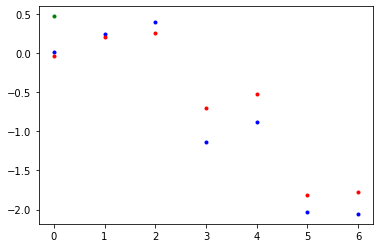

In [64]:
plt.plot(r2_p,".", color="green")
plt.plot(r2_c, ".", color="blue")
plt.plot(r2_cv,".", color="red")
plt.show()

In [65]:
r2_cv

array([-0.04001636,  0.20612531,  0.25772736, -0.69513574, -0.51965236,
       -1.81882561, -1.77997304])

In [66]:
gridCought.best_params_

{'n_components': 3}

In [67]:
gridCought.best_estimator_

Tri_PLS1_grid(n_components=3)

In [68]:
r2_p

0.47216067224326996

In [69]:
r2_c

array([ 0.00893122,  0.24687647,  0.3926318 , -1.13882069, -0.8781626 ,
       -2.03239134, -2.05608282])

# Строю R2 по новому

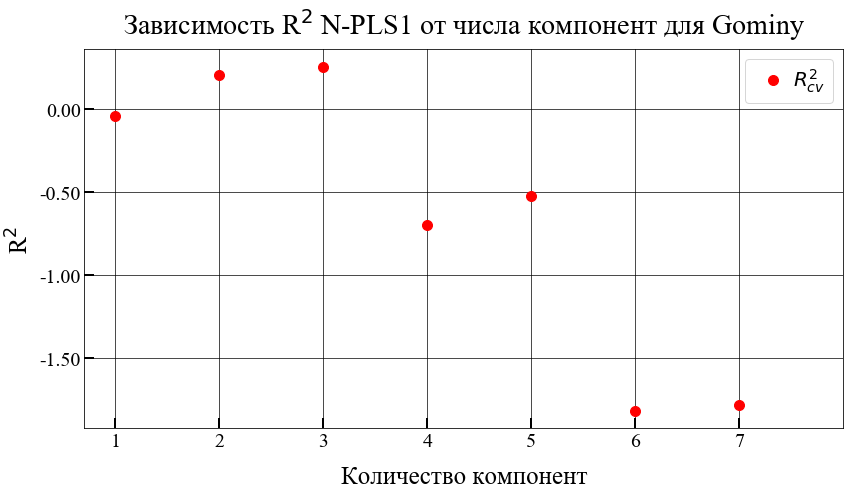

In [72]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$R_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,7,1)) # Задаём места, где будет сетка и метки по оси ох

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа компонент для Gominy", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,9,1), fontsize=20)
axs.set_yticklabels(['-2.00','-1.50','-1.00','-0.50','0.00','0.50','0.30','0.40','0.92','0.94','1.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=1,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=7) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Gominy_new.png', format='png', dpi=300)
plt.savefig("N-PLS1 Gominy_new.svg", format="svg")


plt.show();

# Строю введено-найдено по новому

In [73]:
yTest=y_test+result.medium

In [74]:
y_test

array([ -3.08549775,   2.44997086,   5.45213345, -11.81077856,
         6.32746173])

In [75]:
yTest

array([36.90915996, 42.44462856, 45.44679116, 28.18387915, 46.32211944])

In [76]:
n_predictors=predictors+result.medium

In [77]:
n_predictors

array([43.73650014, 39.6924388 , 46.96068135, 36.01752962, 47.19134987])

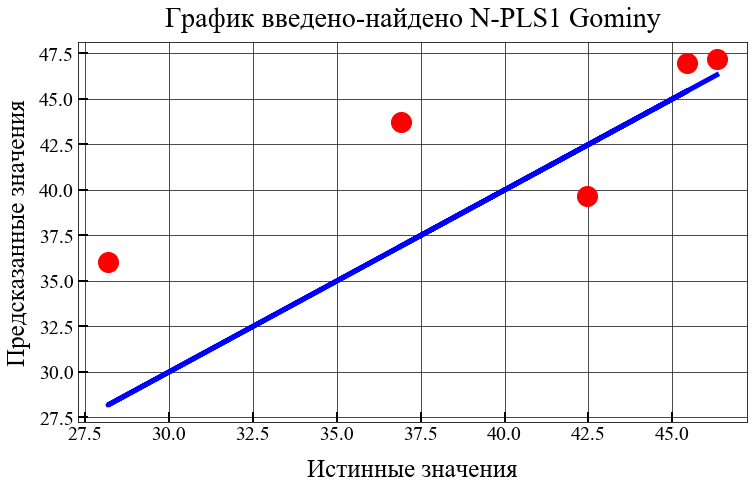

In [80]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Gominy", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['25.0','27.5','30.0','32.5','35.0','37.5','40.0',
                     '42.5','45.0','47.5','50.0'], fontsize=20)
axs.set_yticklabels(['25.0','27.5','30.0','32.5','35.0','37.5','40.0',
                     '42.5','45.0','47.5','50.0'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Gominy_new.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Gominy_new.svg", format="svg")
plt.show();

# Сохраним абсолютно всё в пикль, потому что считать заново - это очень долго.

In [81]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p, 'predict':predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_new_final.pkl.gz', 'wb')
)

### Зделаю ка я применение двух предыдущих классов тоже в виде класса

In [327]:
class run_class(RegressorMixin,BaseEstimator):
    def  __init__(self, testSize=0.1428, column_y=0, components_array=range(1,17), number_vallidations=5):
        self.testSize = testSize
        self.column_y=column_y
        self.components_array = components_array
        self.number_vallidations=number_vallidations
        
    def data_centerng(self,x,y):
        data=centrir(testSize=self.testSize, column_y=self.column_y)
        self.data_cv=data.centering_and_cv(x.copy(),y.copy())
        return self
    
    def cv(self):
        train_error=np.zeros([len(self.components_array)])
        test_error=np.zeros([len(self.components_array)])
        p_error=np.zeros([len(self.components_array)])
        n=0
        for i in self.components_array:
            regressioModel=Tri_PLS1_grid()
            parametrsNames={ 
                'n_components': [i]
            }

            gridCought=GridSearchCV(regressioModel, parametrsNames, cv=self.number_vallidations, return_train_score=True)
            gridCought.fit(self.data_cv.X_train.copy(),self.data_cv.y_train.copy())
            train_error[n]=gridCought.cv_results_[ "mean_train_score"]
            test_error[n]=gridCought.cv_results_[ "mean_test_score" ]
            
            p_error[n]=gridCought.score(self.data_cv.X_test.copy(),self.data_cv.y_test.copy())
            n+=1
        self.train_error=train_error
        self.test_error=test_error
        self.p_error=p_error
        plt.plot(train_error,".", color="red")
        plt.plot(test_error,".", color="blue")
        plt.plot(p_error,".", color="green")
        plt.show();
        return self

In [328]:
mod=run_class(testSize=0.1428,components_array=range(1,13),number_vallidations=5)

In [329]:
#mod.data_centerng(Xdata_numpy["X"][:,160:200,0:15],Ydata)

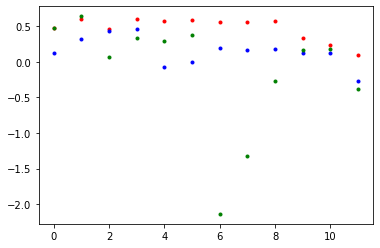

Wall time: 21.6 s


In [330]:
%%time
mod.data_centerng(Xdata_numpy["X"][:,150:200,0:20],Ydata)
result=mod.cv()

In [331]:
result

run_class(column_y=0, components_array=range(1, 13), number_vallidations=5,
          testSize=0.1428)

In [332]:
result.train_error

array([0.46931723, 0.60565466, 0.4612    , 0.60484968, 0.57221136,
       0.58184412, 0.56203913, 0.55663922, 0.56657806, 0.33714295,
       0.23930075, 0.09730211])